In [239]:
import os
import torch
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, cohen_kappa_score
from datasets.UCEIS_dataset import UCEIS_cord, UCEIS_csv
from models import resnet
from utils.provider import get_all_level_bucketing_accuracy, get_stratified_UCEIS_accuracies, plot_confusion_matrix_2, convert_multiclass_to_binary_class
import numpy as np
import matplotlib.pyplot as plt
from utils.detect_blob import DetectBlob

In [240]:
file = open("..//Code//splitted_folder_names//train_folders.txt", "r")
train_folders = file.read().splitlines()
file.close()

file = open("..//Code//splitted_folder_names//val_folders.txt", "r")
val_folders = file.read().splitlines()
file.close()
#val_folders = ['video44', 'video62', 'video15', 'video12', 'video54', 'video102', 'video161', 'video171', 'video138', 'video158', 'video31', 'video4', 'video30', 'video129', 'video110', 'video174', 'video52', 'video84', 'Video_14.mp4', 'video108', 'video160', 'video100', 'video72', 'video143', 'video53', 'Video_1.mp4']

file = open("..//Code//splitted_folder_names//test_folders.txt", "r")
test_folders = file.read().splitlines()
file.close()

from random import shuffle
from math import ceil
def split():
    frame_root = r'C:\Users\ElifKübraÇontar\Desktop\gi\IBD\data_all_frames_540x960'
    all_folders = [f for f in os.listdir(frame_root) if not f.startswith('.')]
    shuffle(all_folders)
    train_set_ratio = 0.7
    val_set_ratio = 0.15
    test_set_ratio = 0.15
    val_set_folder_size = ceil(val_set_ratio * len(all_folders))
    test_set_folder_size = ceil(test_set_ratio * len(all_folders))

    val_folders = all_folders[0:val_set_folder_size]
    test_folders = all_folders[val_set_folder_size:(val_set_folder_size + test_set_folder_size)]
    train_folders = all_folders[(val_set_folder_size + test_set_folder_size):]

    return train_folders, val_folders, test_folders

train_folders, val_folders, test_folders = split()
print(len(train_folders), len(val_folders), len(test_folders))


119 26 26


In [241]:
model_name = "ResNet34"
num_worker=4

frame_root = "..//IBD//data_all_frames_540x960"
cord_project_ID = '5c349378-3e58-4028-af97-96ad9d137dd3'
cord_API_key = 'fL_ktLRxfD90iQayw2dLVg-GVkPxQZVq9p6C6cvpvlg'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device: ", device)

device:  cuda:0


In [242]:
train_set_mean = [0.3683037974792629, 0.2545500826256079, 0.21100532802110092]
train_set_std = [0.32256124182067264, 0.23441272870730917, 0.21096266280494616]
normalize = transforms.Normalize(mean=train_set_mean,
                                 std=train_set_std)

test_transform = transforms.Compose([# DetectBlob(),
                                     transforms.ToTensor(),
                                     normalize])

#val_dataset = UCEIS_csv(val_folders, csv_filename=r'..\label_x50.csv', transform=test_transform)
val_dataset = UCEIS_csv(val_folders, csv_filename=r'..\label_x50.csv', transform=test_transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=num_worker,
                                          pin_memory=True)

print("Images in validation set: "+str(len(val_dataset)))

#467
#3736
#151
#1207
print(len(train_folders))
print(len(val_loader))
print(len(val_loader.dataset))

Images in validation set: 539
119
68
539


In [243]:
#Distrubition of validation set for subscores and UCEIS scores


In [244]:
#state_dict_name = "weights/6_best_"+model_name+".pth.tar"
#state_dict_name = "weights/3_best_"+model_name+".pth.tar"
#state_dict_name = "weights/3_best_"+model_name+".pth.tar"
#state_dict_name = "weights/4_best_"+model_name+"_1.pth.tar"
#state_dict_name = "weights/4_best_"+model_name+"_2.pth.tar"
#state_dict_name = "weights/8_best_"+model_name+".pth.tar"

#### Model I used for Surgease paper results
#state_dict_name = "weights/7_best_"+model_name+".pth.tar"
#state_dict_name = "weights/10_best_"+model_name+".pth.tar"
state_dict_name = "weights/wce_best_0"+model_name+".pth.tar"

if model_name == "ResNet18":
    model = resnet.resnet18(num_classes=[3, 4, 4])
elif model_name == "ResNet34":
    model = resnet.resnet34(num_classes=[3, 4, 4])
elif model_name == "ResNet50":
    model = resnet.resnet50(num_classes=[3, 4, 4])
elif model_name == "DenseNet201":
    model = densenet.densenet201(num_classes=[3, 4, 4])
elif model_name == "DenseNet121":
    model = densenet.densenet121(num_classes=[3, 4, 4])

model.load_state_dict(torch.load(state_dict_name, map_location=device))
model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [245]:
y_true_UCEIS = []
y_true_vascular = []
y_true_bleeding = []
y_true_erosion = []

y_pred_UCEIS = []
y_pred_vascular = []
y_pred_bleeding = []
y_pred_erosion = []

with torch.no_grad():
    for id, (data, target) in enumerate(val_loader):
        data, target = data.to(device), target.to(device)
        target.transpose_(0, 1)

        y_true_vascular.append(target[0].item())
        y_true_bleeding.append(target[1].item())
        y_true_erosion.append(target[2].item())
        y_true_UCEIS.append(target.sum().item())

        output = model(data)

        prediction_0 = output[0].argmax(dim=1, keepdim=True)[0][0].item()
        y_pred_vascular.append(prediction_0)

        prediction_1 = output[1].argmax(dim=1, keepdim=True)[0][0].item()
        y_pred_bleeding.append(prediction_1)

        prediction_2 = output[2].argmax(dim=1, keepdim=True)[0][0].item()
        y_pred_erosion.append(prediction_2)

        y_pred_UCEIS.append(prediction_0 + prediction_1 + prediction_2)


ValueError: only one element tensors can be converted to Python scalars

c:\ProgramData\anaconda3\envs\encord\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\ProgramData\anaconda3\envs\encord\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\ProgramData\anaconda3\envs\encord\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\ProgramData\anaconda3\envs\encord\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\ProgramData\anaconda3\envs\encord\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\ProgramData\anaconda3\envs\encord\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\ProgramData\anaconda3\

Vascular Accuracy:  nan
Confusion matrix, without normalization
[[0 0 0]
 [0 0 0]
 [0 0 0]]


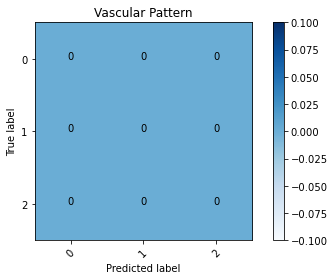

---------------------------------------

Bleeding Accuracy:  nan
Confusion matrix, without normalization
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]


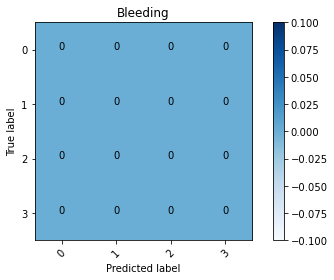

---------------------------------------

Erosion Accuracy:  nan
Confusion matrix, without normalization
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]


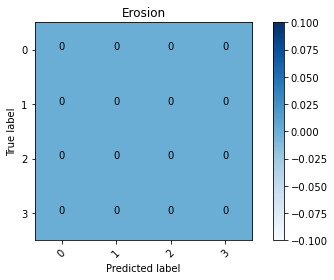

---------------------------------------

UCEIS Accuracy:  nan
Confusion matrix, without normalization
[[0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x00000274D2990280>
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\envs\encord\lib\site-packages\torch\utils\data\dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "c:\ProgramData\anaconda3\envs\encord\lib\site-packages\torch\utils\data\dataloader.py", line 1316, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


KeyboardInterrupt: 

In [ ]:
cm_vascular = confusion_matrix(y_true_vascular, y_pred_vascular, labels=[0, 1, 2])
accuracy_vascular = accuracy_score(y_true_vascular, y_pred_vascular)

cm_bleeding = confusion_matrix(y_true_bleeding, y_pred_bleeding, labels=[0, 1, 2, 3])
accuracy_bleeding = accuracy_score(y_true_bleeding, y_pred_bleeding)

cm_erosion = confusion_matrix(y_true_erosion, y_pred_erosion, labels=[0, 1, 2, 3])
accuracy_erosion = accuracy_score(y_true_erosion, y_pred_erosion)

cm_UCEIS = confusion_matrix(y_true_UCEIS, y_pred_UCEIS, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8])
accuracy_UCEIS = accuracy_score(y_true_UCEIS, y_pred_UCEIS)


print("Vascular Accuracy: ", accuracy_vascular)
plot_confusion_matrix_2(cm_vascular, classes=["0", "1", "2"], title="Vascular Pattern")
plt.show()
print("---------------------------------------\n")

print("Bleeding Accuracy: ", accuracy_bleeding)
plot_confusion_matrix_2(cm_bleeding, classes=["0", "1", "2", "3"], title="Bleeding")
plt.show()
print("---------------------------------------\n")

print("Erosion Accuracy: ", accuracy_erosion)
plot_confusion_matrix_2(cm_erosion, classes=["0", "1", "2", "3"], title="Erosion")
plt.show()
print("---------------------------------------\n")

print("UCEIS Accuracy: ", accuracy_UCEIS)
plot_confusion_matrix_2(cm_UCEIS, classes=["0", "1", "2", "3", "4", "5", "6", "7", "8"], title="UCEIS")
plt.show()

**Bucketing scores for different bucket levels**

[0.41304347826086957, 0.788647342995169, 0.9251207729468599, 0.9770531400966184, 0.9939613526570048, 0.998792270531401, 1.0, 1.0, 1.0]


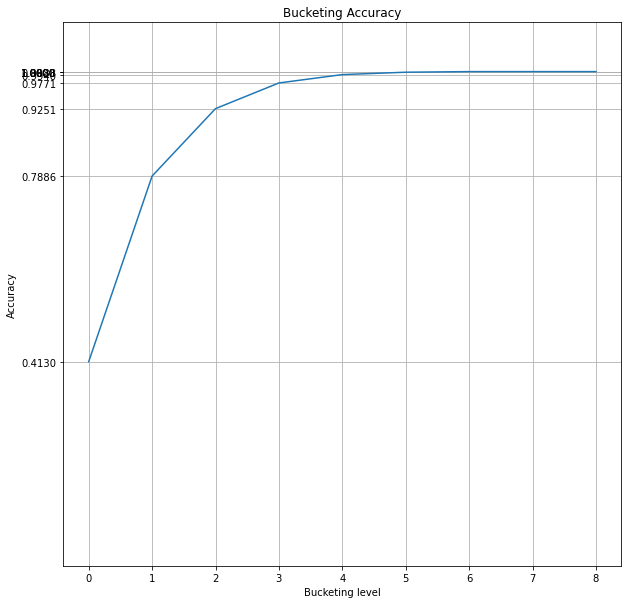

In [ ]:
bucketing_scores = get_all_level_bucketing_accuracy(y_true_UCEIS, y_pred_UCEIS)
print(bucketing_scores)
plt.figure(figsize=(10,10))
plt.plot(bucketing_scores)
plt.title("Bucketing Accuracy")
plt.xlabel("Bucketing level")
plt.ylabel("Accuracy")
plt.yticks(bucketing_scores)
plt.grid(True)
plt.ylim(0, 1.1)
plt.show()

**Video level quadratic weighted kappa score**

In [ ]:
quadratic_kappa_score = cohen_kappa_score(y_true_UCEIS, y_pred_UCEIS, weights="quadratic")
print("Quadratic Kappa Score (9-classes): ", quadratic_kappa_score)

Quadratic Kappa Score (9-classes):  0.6855877011347994


In [ ]:
quadratic_kappa_score = cohen_kappa_score(y_true_bleeding, y_pred_bleeding, weights="quadratic")
print("Quadratic Kappa Score (9-classes): ", quadratic_kappa_score)

Quadratic Kappa Score (9-classes):  0.5939414778780516


In [ ]:
quadratic_kappa_score = cohen_kappa_score(y_true_vascular, y_pred_vascular, weights="quadratic")
print("Quadratic Kappa Score (9-classes): ", quadratic_kappa_score)

Quadratic Kappa Score (9-classes):  0.7135759263280242


In [ ]:
quadratic_kappa_score = cohen_kappa_score(y_true_erosion, y_pred_erosion, weights="quadratic")
print("Quadratic Kappa Score (9-classes): ", quadratic_kappa_score)

Quadratic Kappa Score (9-classes):  0.24565743269605933


**Video level remission results**

UCEIS Accuracy (0 vs 1-8):  0.8599033816425121
Confusion matrix, without normalization
[[157  29]
 [ 87 555]]


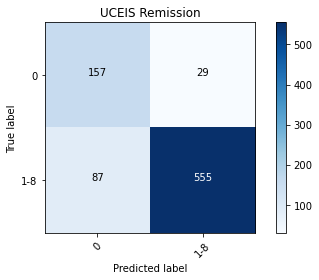

In [ ]:
y_true_remission = convert_multiclass_to_binary_class(y_true_UCEIS)
y_pred_remission = convert_multiclass_to_binary_class(y_pred_UCEIS)

cm_UCEIS_remission = confusion_matrix(y_true_remission, y_pred_remission, labels=[0, 1])
accuracy_UCEIS_remission = accuracy_score(y_true_remission, y_pred_remission)

print("UCEIS Accuracy (0 vs 1-8): ", accuracy_UCEIS_remission)
plot_confusion_matrix_2(cm_UCEIS_remission, classes=["0", "1-8"], title="UCEIS Remission")
plt.show()

**Video level remission kappa score**

In [ ]:
kappa_score = cohen_kappa_score(y_true_remission, y_pred_remission)
print("Remission Kappa Score: ", kappa_score)

Remission Kappa Score:  0.6379263548357912


In [ ]:
cm_UCEIS[0][0] + cm_UCEIS[0][1]+cm_UCEIS[1][1] + cm_UCEIS[1][0]

266

In [ ]:
sum(cm_UCEIS[3:][0]) + sum(cm_UCEIS[3:][1]) + sum(cm_UCEIS[0][3:]) + sum(cm_UCEIS[1][3:])

268

In [ ]:
cm_UCEIS

array([[157,   7,  18,   1,   3,   0,   0,   0,   0],
       [ 75,  27,  65,   7,  13,   2,   2,   1,   0],
       [  8,  31,  66,  25,   6,   8,   2,   2,   0],
       [  3,  10,  33,  45,  21,  17,   0,   1,   0],
       [  1,   4,  17,  26,  35,  12,  12,   2,   0],
       [  0,   1,   8,  15,  10,  10,   2,   0,   3],
       [  0,   0,   4,   1,   3,   4,   1,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   1]], dtype=int64)

In [ ]:
import pandas as pd
df = pd.DataFrame(cm_UCEIS)
df.to_csv('./results/train_test_w_no_val_uceis.csv')

In [ ]:
import pandas as pd
df = pd.DataFrame(cm_vascular)
df.to_csv('./results/train_test_w_no_val_vascular.csv')

In [ ]:
import pandas as pd
df = pd.DataFrame(cm_bleeding)
df.to_csv('./results/train_test_w_no_val_bleeding.csv')

In [ ]:
import pandas as pd
df = pd.DataFrame(cm_erosion)
df.to_csv('./results/train_test_w_no_val_erosion.csv')

In [ ]:
import pandas as pd
df = pd.DataFrame(cm_UCEIS)

In [ ]:
(cm_UCEIS[4:,4:])


array([[35, 12, 12,  2,  0],
       [10, 10,  2,  0,  3],
       [ 3,  4,  1,  0,  0],
       [ 0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1]], dtype=int64)

In [ ]:
(cm_UCEIS[0:4,0:4])

array([[157,   7,  18,   1],
       [ 75,  27,  65,   7],
       [  8,  31,  66,  25],
       [  3,  10,  33,  45]], dtype=int64)

In [ ]:
(sum(sum((cm_UCEIS[0:4,0:4]))) + sum(sum((cm_UCEIS[4:,4:]))) )/ sum(sum(cm_UCEIS))

0.8128019323671497

In [ ]:
2817.0/2897

0.9723852260959613

In [ ]:
sum(sum(cm_UCEIS))

828

In [ ]:
(sum(sum((cm_UCEIS[0:2,0:2]))) + sum(sum((cm_UCEIS[2:,2:]))) )/ sum(sum(cm_UCEIS))

0.7946859903381642

In [ ]:
cm_UCEIS[2:,2:]

array([[66, 25,  6,  8,  2,  2,  0],
       [33, 45, 21, 17,  0,  1,  0],
       [17, 26, 35, 12, 12,  2,  0],
       [ 8, 15, 10, 10,  2,  0,  3],
       [ 4,  1,  3,  4,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  1]], dtype=int64)

In [ ]:
7667.0/8376

0.9153533906399236

In [ ]:
(cm_UCEIS[2:,2:])

array([[66, 25,  6,  8,  2,  2,  0],
       [33, 45, 21, 17,  0,  1,  0],
       [17, 26, 35, 12, 12,  2,  0],
       [ 8, 15, 10, 10,  2,  0,  3],
       [ 4,  1,  3,  4,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  1]], dtype=int64)

In [ ]:
(cm_UCEIS[0:2,0:2])

array([[157,   7],
       [ 75,  27]], dtype=int64)

In [ ]:
(sum(cm_UCEIS[2:][0]) + sum(cm_UCEIS[2:][1]) + sum(cm_UCEIS[0][2:]) + sum(cm_UCEIS[1][2:]))*1.0 / sum(sum(cm_UCEIS))

0.47101449275362317

In [ ]:
8233/19396.0

0.424468962672716

In [ ]:
1-_

0.575531037327284

In [ ]:
###Fold 1 : 83.56 1 bucket , 87,6 remission
###Fold 2 : 84.74 1 bucket , 91.9 remission

In [ ]:
len(y_pred_vascular)

828

In [ ]:
import pandas as pd

d=pd.DataFrame((test_loader.dataset.frame_paths))
d[1] = d[0].str.split('/').apply(lambda x:x[-3])
d[1].unique()

NameError: name 'test_loader' is not defined

In [ ]:
file = open("splitted_folder_names/predetermined_test_folders.txt", "r")
test_folders = file.read().splitlines()

In [ ]:
test_folders

['UC10-0.mp4',
 'UC15-1.mp4',
 'UC21-2.mp4',
 'UC14-4.mp4',
 'UC53-4.mp4',
 'UC61-4.mp4',
 'UC79-4.mp4',
 'UC29-5.mp4',
 'UC30-5.mp4',
 'UC1-6.mp4']

In [ ]:
len(y_true_UCEIS)

3297

In [ ]:
import gc
import torch

gc.collect()

torch.cuda.empty_cache()
gc.collect()


0

3297

In [ ]:
np.array([[3249,  281,    0,    0,    0,    0,    0,    0,    0],
       [ 417,  863,    9,    0,    0,    0,    0,    0,    0],
       [ 120,  575,  203,   16,    2,    0,    0,    0,    0],
       [   0,    5,   22,   15,   67,    5,    0,    0,    0],
       [   0,    0,    1,    4, 1209,  153,    0,    0,    0],
       [   0,    0,    0,    5,  191,  494,    0,    1,    0],
       [   0,    0,    0,    0,  144,   24,    0,    0,    0],
       [   0,    0,    0,    0,    0,  301,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0]])

array([[3249,  281,    0,    0,    0,    0,    0,    0,    0],
       [ 417,  863,    9,    0,    0,    0,    0,    0,    0],
       [ 120,  575,  203,   16,    2,    0,    0,    0,    0],
       [   0,    5,   22,   15,   67,    5,    0,    0,    0],
       [   0,    0,    1,    4, 1209,  153,    0,    0,    0],
       [   0,    0,    0,    5,  191,  494,    0,    1,    0],
       [   0,    0,    0,    0,  144,   24,    0,    0,    0],
       [   0,    0,    0,    0,    0,  301,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0]])

In [ ]:
cm_UCEIS = _

In [ ]:
sum(sum(cm_UCEIS))

8376

In [ ]:
[[ 675  322]
 [ 314 3833]]